# Difussion equation

Solving the poisson equation $u_t-\Delta u = f$ using a physics informed neural network in multi dim.

### Manufactured solution


We use $u = t\sin (x+y)$ for $x\in [-1,1]^2$, $t\in[0,1]$ to manufacture the rhs of the difussion equation above.

### Importing packages

In [49]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### Manufacturing data for trainig

In [104]:
np.random.seed(123)
pde_data_size = 10000

#space data
space_dim = 2
X_tr_pde = np.random.uniform(-1,1,pde_data_size*space_dim).reshape(pde_data_size,space_dim)

#temporal data
X_tr_time = np.random.uniform(0,1,pde_data_size).reshape(pde_data_size,1)

X_tr_pde = np.concatenate([X_tr_pde, X_tr_time],axis=1)

In [105]:
X_tr_pde.shape

(10000, 3)

### Looking at the scatter plot of data

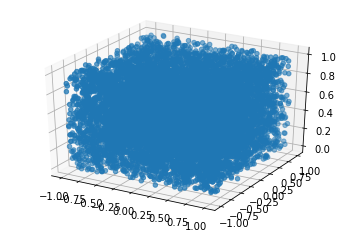

In [106]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_tr_pde[:,0],X_tr_pde[:,1],X_tr_pde[:,2])


### Defining the labels(true values) for the training data

In [107]:
Y_tr_pde = np.zeros((X_tr_pde.shape[0],1))
# Y_tr_pde = X_tr_pde[:,0:1]


In [108]:
Y_tr_pde = np.concatenate([Y_tr_pde,np.zeros((Y_tr_pde.shape[0],1))],axis=1)
Y_tr_pde.shape

(10000, 2)

## BC data 

In [109]:
bc_data_size = 100

X_bc_left = np.random.uniform(-1.,1.,bc_data_size).reshape(bc_data_size,1)
X_bc_left = np.concatenate([-1*np.ones((bc_data_size,1)), X_bc_left], axis=1)
X_bc_left = np.concatenate([X_bc_left,np.random.uniform(0,1.,bc_data_size).reshape(bc_data_size,1)], axis=1)

X_bc_bottom = np.random.uniform(-1.,1.,bc_data_size).reshape(bc_data_size,1)
X_bc_bottom = np.concatenate([X_bc_bottom, -1*np.ones((bc_data_size,1))], axis=1)
X_bc_bottom = np.concatenate([X_bc_bottom, np.random.uniform(0,1.,bc_data_size).reshape(bc_data_size,1)], axis=1)

X_bc_right = np.random.uniform(-1.,1.,bc_data_size).reshape(bc_data_size,1)
X_bc_right = np.concatenate([1*np.ones((bc_data_size,1)), X_bc_right], axis=1)
X_bc_right = np.concatenate([X_bc_right,np.random.uniform(0,1.,bc_data_size).reshape(bc_data_size,1)], axis=1)

X_bc_top = np.random.uniform(-1.,1.,bc_data_size).reshape(bc_data_size,1)
X_bc_top = np.concatenate([X_bc_top, 1*np.ones((bc_data_size,1))], axis=1)
X_bc_top = np.concatenate([X_bc_top,np.random.uniform(0,1.,bc_data_size).reshape(bc_data_size,1)], axis=1)

X_bc = np.concatenate([X_bc_left, X_bc_right, X_bc_bottom, X_bc_top],axis=0)

In [114]:
Y_bc = np.sin(X_bc[:,0:1] + X_bc[:,1:2]) * X_bc[:,2:3]
Y_bc = np.concatenate([Y_bc, np.ones((Y_bc.shape[0],1))], axis=1 )

In [116]:
# dom_data_size = 1000
# X_domain  = np.random.uniform(-1,1,dom_data_size*dim_d).reshape(dom_data_size,dim_d)

# Y_domain = X_domain[:,0:1]**2 + X_domain[:,1:]**2 
# Y_domain = np.concatenate([Y_domain, np.ones((Y_domain.shape[0],1))], axis=1)

In [117]:
# X_tr = np.concatenate((X_tr_pde, X_bc, X_domain), axis=0)
# Y_tr = np.concatenate((Y_tr_pde, Y_bc, Y_domain), axis=0)
X_tr = np.concatenate((X_tr_pde, X_bc), axis=0)
Y_tr = np.concatenate((Y_tr_pde, Y_bc), axis=0)

## Training the model

In [119]:
from tensorflow.keras import backend as K
class FlowNet(tf.keras.Model):

    def __init__(self, space_dim=1, time_dep=False):
        super(FlowNet, self).__init__()
        
        self.time_dep = time_dep
        self.dense_1 = keras.layers.Dense(20, activation="tanh",
                                          name="dense_1")
        self.dense_2 = keras.layers.Dense(20, activation="tanh",
                                         name="dense_2")
        self.dense_3 = keras.layers.Dense(20, activation="tanh",
                                         name="dense_3")
        self.final_layer = keras.layers.Dense(1,
                                         name="final_layer")

    def findGrad(self,func,argm):
        try:
            return keras.layers.Lambda(lambda z: [tf.gradients(z[0],x_i,
                                                               unconnected_gradients='zero')
                                                  for x_i in z[1] ]) ([func,argm])
        except Exception as e:
            print("Error occured in finding the time derrivative  lambda layer of type {} as follows: \n{}".format(type(e)),e)
            
    def findTimeDer(self,func,argm):
        try:
            return keras.layers.Lambda(lambda z: tf.gradients(z[0],z[1],
                                                               unconnected_gradients='zero')) ([func,argm])
        except Exception as e:
            print("Error occured in find gradient lambda layer of type {} as follows: \n{} ".format(type(e)),e)
            
            
    def findSecGrad(self,func,argm):
        try:
            # list containng diagonal entries of hessian matrix. Note that  tf.gradients 
            #returns a list of tensors and hence thats why we have  a [0] at the end of  
            #the tf.gradients fucntion as tf.gradients(func,argm) [0]
            del_sq_layer = keras.layers.Lambda( lambda z: [ tf.gradients(z[0][i], z[1][i],
                                                              unconnected_gradients='zero') [0]
                                                  for i in range(len(z[1])) ] ) ([func,argm])
            return sum(del_sq_layer)
                
        except Exception as e:
            print("Error occured in find laplacian lambda layer of type {} as follows: \n{}".format(type(e)),e)
    
    #final layer representing the lhs P(x,t) of PDE P(x,t)=0
    def findPdeLayer(self, time_der=0, laplacian, input_arg):
        try:
            return keras.layers.Lambda(lambda z: z[0] - z[1] - tf.sin(z[2][0]+z[2][1]) - 
                                       2*z[2][2]*tf.sin(z[2][0]+z[2][1])) ([time_der, laplacian, input_arg])
        except Exception as e:
            print("Error occured in finding pde  lambda layer of type {} as follows: \n{}".format(type(e)),e)
    
    
    def call(self, inputs):
        """
        Note that inputs should always be given as a list with the last element of the list representing the 
        dimension corresponding to time.
        """
        if self.time_dep:
            try:
                assert(len(inputs) > 1)
                input_space = inputs[:-1]
                input_time = inputs[-1]
            except Exception as e:
                print("Error occured while separating spacial and temporal data from inputs,\
                make sure that spacio-temporal data is being used to for training and \
                x=[space_dim1,..,space_dimn,time_dim]. More details on error below:\n", type(e), e)
        else:
            input_space = inputs
        
        #concatening all the input data (space and time dimensions) making it 
        #read to be passed to the hidden layers
        inputs_conc = keras.layers.concatenate(inputs) 
        
        #hidden layers
        layer_1 = self.dense_1(inputs_conc)
        layer_2 = self.dense_2(layer_1)
        layer_3 = self.dense_3(layer_2)
        
        #output layer, this is typically the solution function
        output_layer = self.final_layer(layer_3)
        
        #pde specific layers
        if self.time_dep: 
            grad_layer = self.findGrad(output_layer, input_space)
            time_der_layer = self.findTimeDer(output_layer, input_time)
            laplace_layer = self.findSecGrad(grad_layer, input_space)
            pde_layer = self.findPdeLayer(time_der_layer, laplace_layer, inputs)
        else: #if the problem is not time dependent
            grad_layer = self.findGrad(output_layer, input_space)
#             time_der_layer = self.findTimeDer(output_layer, input_time)
            laplace_layer = self.findSecGrad(grad_layer, input_space)
            pde_layer = self.findPdeLayer(time_der_layer, 0, inputs)
        
        return output_layer, pde_layer




SyntaxError: non-default argument follows default argument (<ipython-input-119-75104498527b>, line 47)

In [17]:
custom_model = CustomModel()

In [18]:
#Loss coming from the boundary terms
def u_loss(y_true, y_pred):
#     print("\n\nreached here 1 \n\n\n")
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    u_sq_error = (1/2)*tf.square(y_true_act-y_pred)
#     print("\n\nreached here 2 \n\n\n")
#     print("\nu_loss: ",tf.where(at_boundary, u_sq_error, 0.))
    return tf.where(at_boundary, u_sq_error, 0.)

#Loss coming from the PDE constrain
def pde_loss(y_true, y_pred):
    y_true_act = y_true[:,:-1]
    at_boundary = tf.cast(y_true[:,-1:,],bool)
    #need to change this to just tf.square(y_pred) after pde constrain is added to grad_layer
    pde_sq_error = (1/2)*tf.square(y_pred)
#     print("\npde_loss: ",tf.where(at_boundary,0.,pde_sq_error))
    return tf.where(at_boundary,0.,pde_sq_error)

In [19]:
custom_model.compile(loss=[u_loss,pde_loss], optimizer="adam")
# custom_model.compile(loss=u_loss, optimizer=keras.optimizers.SGD(lr=1e-3))

In [20]:
custom_model.fit(x=[X_tr[:,0:1], X_tr[:,1:2]], y=[Y_tr, Y_tr], epochs=10)

Epoch 1/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0605 - output_1_loss: 0.0107 - output_2_loss: 0.0498
Epoch 2/10
375/375 [==============================] - 2s 7ms/step - loss: 0.0153 - output_1_loss: 0.0025 - output_2_loss: 0.0128
Epoch 3/10
375/375 [==============================] - 2s 6ms/step - loss: 0.0026 - output_1_loss: 5.7837e-04 - output_2_loss: 0.0021
Epoch 4/10
375/375 [==============================] - 2s 7ms/step - loss: 0.0011 - output_1_loss: 3.1162e-04 - output_2_loss: 7.8003e-04
Epoch 5/10
375/375 [==============================] - 3s 7ms/step - loss: 5.5683e-04 - output_1_loss: 1.8372e-04 - output_2_loss: 3.7311e-04
Epoch 6/10
375/375 [==============================] - 3s 9ms/step - loss: 2.9197e-04 - output_1_loss: 1.0215e-04 - output_2_loss: 1.8983e-04
Epoch 7/10
375/375 [==============================] - 3s 9ms/step - loss: 1.8337e-04 - output_1_loss: 7.6001e-05 - output_2_loss: 1.0736e-04
Epoch 8/10
375/375 [=============================

In [21]:
# custom_model.compile(loss=[u_loss,pde_loss], optimizer=keras.optimizers.SGD(lr=1e-4))
# custom_model.fit(x=[X_tr[:,0:1], X_tr[:,1:2]], y=[Y_tr, Y_tr], epochs=10)

### Testing the model

In [22]:
# X_test_st = np.random.uniform(-0.5,0.5,20*dim_d).reshape(20,dim_d)

In [23]:
X_test_st = np.random.uniform(-1,1,100*dim_d).reshape(100,dim_d)


In [24]:

#custom_model.evaluate(x=[X_test_st[:,0:1], X_test_st[:,1:2]], y=[Y_tr[-100:,:], Y_tr[-100:,:]])

In [25]:
Y_test = custom_model.predict(x=[X_test_st[:,0:1], X_test_st[:,1:2]])[0]

In [26]:
Y_test_true = np.sin(X_test_st[:,0:1] + X_test_st[:,1:2])
Y_eval = np.concatenate([Y_test_true,np.ones((Y_test_true.shape[0],1))], axis=1)

In [27]:
custom_model.evaluate(x=[X_test_st[:,0:1], X_test_st[:,1:2]], y= Y_eval)

4/4 [==============================] - 0s 10ms/step - loss: 8.3950e-06 - output_1_loss: 8.3950e-06 - output_2_loss: 0.0000e+00


[8.395009899686556e-06, 8.395009899686556e-06, 0.0]

In [28]:
np.concatenate([Y_test_true, Y_test], axis=1)

array([[ 0.59469667,  0.59532952],
       [ 0.99031683,  0.99210829],
       [ 0.84204876,  0.84424496],
       [ 0.78671795,  0.78880805],
       [-0.3454792 , -0.34360591],
       [-0.29067741, -0.28836995],
       [-0.99660119, -0.98933917],
       [-0.63191394, -0.62980747],
       [ 0.16737703,  0.16869868],
       [ 0.07316043,  0.07629324],
       [ 0.83687563,  0.84005171],
       [ 0.86441854,  0.86879808],
       [-0.21504471, -0.21314435],
       [-0.03181573, -0.02820441],
       [-0.58109187, -0.5796231 ],
       [ 0.43877001,  0.44163221],
       [ 0.54653942,  0.54985428],
       [-0.36237624, -0.35898542],
       [-0.04007365, -0.0358161 ],
       [-0.99980921, -0.99146777],
       [-0.24818418, -0.24576373],
       [ 0.19087545,  0.19240806],
       [-0.02027401, -0.01662918],
       [-0.21549582, -0.21366596],
       [ 0.12579684,  0.12610945],
       [-0.17032734, -0.16853179],
       [ 0.37557967,  0.37854469],
       [ 0.40351828,  0.40366328],
       [-0.37347514,

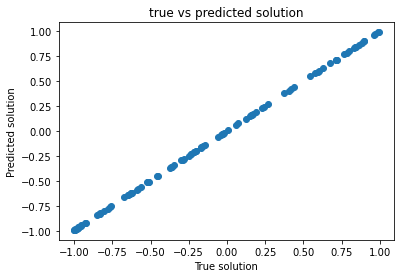

In [29]:
plt.scatter(Y_test_true,Y_test)
plt.title("true vs predicted solution")
plt.xlabel("True solution")
plt.ylabel("Predicted solution")
plt.show()

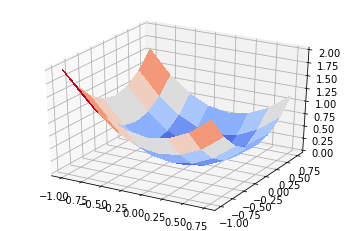

In [30]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

# Make data.
X = np.arange(-1, 1, 0.25)
Y = np.arange(-1, 1, 0.25)
X, Y = np.meshgrid(X, Y)
R = X**2 + Y**2
# Z = np.sin(R)

# Plot the surface.
surf = ax.plot_surface(X, Y, R, cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)
